<a href="https://colab.research.google.com/github/Sumit189/PERFORMANCE-ANALYSIS-OF-DL-AND-ML/blob/main/PERFORMANCE_ANALYSIS_OF_DEEP_LEARNING_AND_MACHINE_LEARNING_TECHNIQUES_FOR_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset

In [1]:
!git clone "https://github.com/prajnasb/observations.git"

Cloning into 'observations'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1638 (delta 9), reused 0 (delta 0), pack-reused 1604
Receiving objects: 100% (1638/1638), 75.94 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
!mkdir dataset

In [3]:
!mv /content/observations/experiements/dest_folder/* /content/dataset/

In [4]:
!rm -rf /content/dataset/*.csv

#Data Preprocessing

In [5]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [6]:
import cv2,os
from skimage import io
from tqdm import tqdm

data_path='dataset'

for r,d,f in os.walk(data_path):
  for files in f:
    img_path=r+"/"+files
    img=io.imread(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    os.remove(img_path)
    cv2.imwrite(img_path,gray)

In [7]:
# loading data in batch
train_dir='dataset/train/'
test_dir='dataset/test/'
val_dir='dataset/val/'

BATCH_SIZE=32
seed=123
IMG_SIZE=(100,100)
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,shuffle=True,
                                        batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_ds=tf.keras.preprocessing.image_dataset_from_directory(test_dir,shuffle=True,
                                        batch_size=BATCH_SIZE,image_size=IMG_SIZE)
val_ds=tf.keras.preprocessing.image_dataset_from_directory(val_dir,shuffle=True,
                                        batch_size=BATCH_SIZE,image_size=IMG_SIZE)


Found 1315 files belonging to 2 classes.
Found 194 files belonging to 2 classes.
Found 142 files belonging to 2 classes.


In [8]:
class_names=train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


In [9]:
num_batch=0
for image_batch,label_batch in train_ds:
    num_batch+=1
print(num_batch)

42


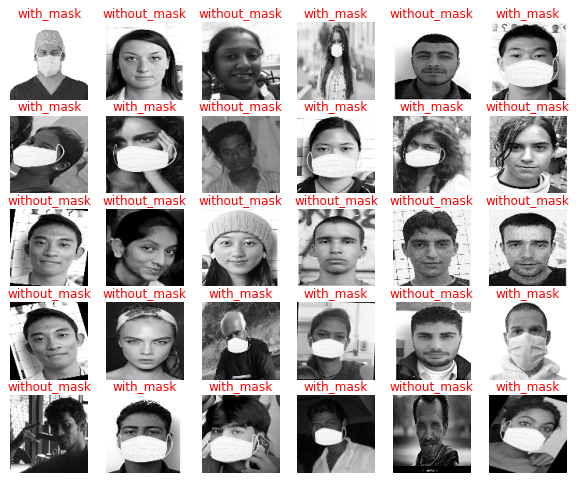

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_ds.take(1):
    for i in range(30):
        plt.subplot(6,6,i+1)
        plt.imshow(image_batch[i]/255.0)
        plt.title(class_names[label_batch[i]],c='r')
        plt.axis('off')

#Technique 1

In [11]:
resize_rescale=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(100,100),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
model=tf.keras.Sequential([
    resize_rescale,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

##Adam

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
best_adam_model_file = "adam.h5"
best_adam_model = ModelCheckpoint(best_adam_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)

In [15]:
hist=model.fit(train_ds,
               validation_data=val_ds,
               epochs=10,
               callbacks=[best_adam_model])

Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.6662
Epoch 00001: val_accuracy improved from -inf to 0.85915, saving model to adam.h5
42/42 [==============================] - 3s 82ms/step - loss: 0.6072 - accuracy: 0.6662 - val_loss: 0.3546 - val_accuracy: 0.8592
Epoch 2/10
39/42 [==========================>...] - ETA: 0s - loss: 0.3440 - accuracy: 0.8566
Epoch 00002: val_accuracy improved from 0.85915 to 0.93662, saving model to adam.h5
42/42 [==============================] - 3s 72ms/step - loss: 0.3366 - accuracy: 0.8608 - val_loss: 0.1514 - val_accuracy: 0.9366
Epoch 3/10
39/42 [==========================>...] - ETA: 0s - loss: 0.2300 - accuracy: 0.9054
Epoch 00003: val_accuracy did not improve from 0.93662
42/42 [==============================] - 3s 77ms/step - loss: 0.2251 - accuracy: 0.9072 - val_loss: 0.1538 - val_accuracy: 0.9296
Epoch 4/10
40/42 [===========================>..] - ETA: 0s - loss: 0.1459 - accuracy: 0.9484
Epoch 00004: v

In [16]:
model=load_model(best_adam_model_file)
test_loss,test_acc=model.evaluate(test_ds)
print(test_acc)

7/7 [==============================] - 0s 9ms/step - loss: 0.1571 - accuracy: 0.9536
0.9536082744598389


##RMSprop

In [17]:
model2=tf.keras.Sequential([
    resize_rescale,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [18]:
model2.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
best_rms_model_file = "rms.h5"
best_rms_model = ModelCheckpoint(best_rms_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)

In [20]:
hist2=model2.fit(train_ds,
                 validation_data=val_ds,
                 epochs=10,
                 callbacks=[best_rms_model])

Epoch 1/10
40/42 [===========================>..] - ETA: 0s - loss: 0.7326 - accuracy: 0.6352
Epoch 00001: val_accuracy improved from -inf to 0.75352, saving model to rms.h5
42/42 [==============================] - 3s 79ms/step - loss: 0.7264 - accuracy: 0.6380 - val_loss: 0.4682 - val_accuracy: 0.7535
Epoch 2/10
41/42 [============================>.] - ETA: 0s - loss: 0.4144 - accuracy: 0.8255
Epoch 00002: val_accuracy improved from 0.75352 to 0.88732, saving model to rms.h5
42/42 [==============================] - 3s 76ms/step - loss: 0.4138 - accuracy: 0.8259 - val_loss: 0.2696 - val_accuracy: 0.8873
Epoch 3/10
39/42 [==========================>...] - ETA: 0s - loss: 0.2805 - accuracy: 0.8846
Epoch 00003: val_accuracy did not improve from 0.88732
42/42 [==============================] - 3s 77ms/step - loss: 0.2753 - accuracy: 0.8875 - val_loss: 0.8217 - val_accuracy: 0.6831
Epoch 4/10
39/42 [==========================>...] - ETA: 0s - loss: 0.1962 - accuracy: 0.9183
Epoch 00004: val

In [21]:
model2=load_model(best_rms_model_file)
test_loss2,test_acc2=model2.evaluate(test_ds)
print(test_acc2)

7/7 [==============================] - 0s 5ms/step - loss: 0.1923 - accuracy: 0.9227
0.9226804375648499


##SGD

In [22]:
model3=tf.keras.Sequential([
    resize_rescale,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [23]:
model3.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
best_sgd_model_file = "sgd.h5"
best_sgd_model = ModelCheckpoint(best_sgd_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)

In [25]:
hist3=model3.fit(train_ds,
                 validation_data=val_ds,
                 epochs=10,
                 callbacks=[best_sgd_model])

Epoch 1/10
40/42 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5250
Epoch 00001: val_accuracy improved from -inf to 0.69718, saving model to sgd.h5
42/42 [==============================] - 3s 73ms/step - loss: 0.6849 - accuracy: 0.5285 - val_loss: 0.6679 - val_accuracy: 0.6972
Epoch 2/10
39/42 [==========================>...] - ETA: 0s - loss: 0.6614 - accuracy: 0.6178
Epoch 00002: val_accuracy did not improve from 0.69718
42/42 [==============================] - 3s 73ms/step - loss: 0.6600 - accuracy: 0.6221 - val_loss: 0.6301 - val_accuracy: 0.5282
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6487
Epoch 00003: val_accuracy did not improve from 0.69718
42/42 [==============================] - 3s 77ms/step - loss: 0.6244 - accuracy: 0.6487 - val_loss: 0.5782 - val_accuracy: 0.6831
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6837
Epoch 00004: val_accuracy did not improve fr

In [26]:
model=load_model(best_sgd_model_file)
test_loss3,test_acc3=model3.evaluate(test_ds)
print(test_acc3)

7/7 [==============================] - 0s 6ms/step - loss: 0.7085 - accuracy: 0.6237
0.623711347579956


##Plots

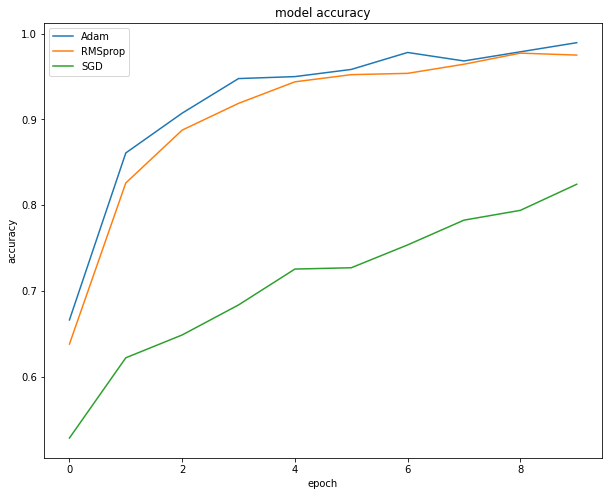

In [27]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam','RMSprop','SGD'], loc='upper left')
plt.show()

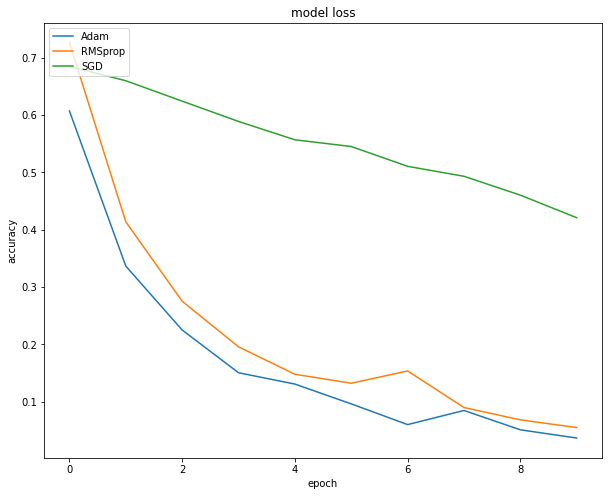

In [28]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist3.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam','RMSprop','SGD'], loc='upper left')
plt.show()

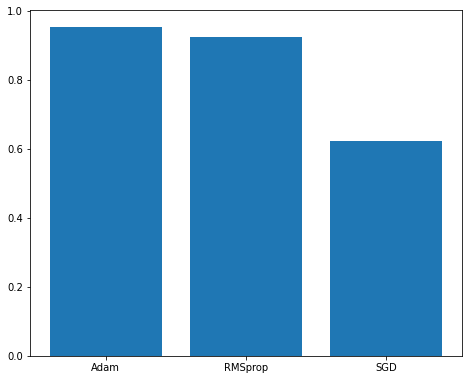

In [29]:
#Accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,0.6,0.6])
optmizers = ['Adam', 'RMSprop', 'SGD']
acc = [test_acc,test_acc2,test_acc3]
ax.bar(optmizers,acc)
plt.show()

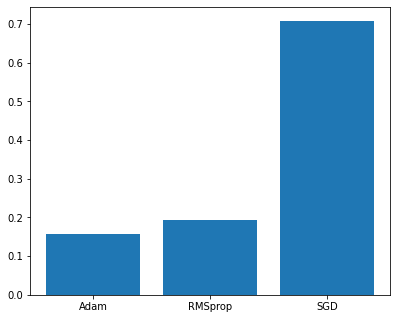

In [30]:
#Loss comparison
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
optmizers = ['Adam', 'RMSprop', 'SGD']
loss = [test_loss,test_loss2,test_loss3]
ax.bar(optmizers,loss)
plt.show()

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)      

#Technique 2

In [32]:
train_dir='dataset/train/'
test_dir='dataset/test/'

In [33]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                image_size=(224,224))

Found 1315 files belonging to 2 classes.


In [34]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                           image_size=(224,224))

Found 194 files belonging to 2 classes.


In [35]:
train_batches=tf.data.experimental.cardinality(train_ds)
test_batches=tf.data.experimental.cardinality(test_ds)
print('Traing batch',train_batches.numpy())
print('Test batch',test_batches.numpy())

Traing batch 42
Test batch 7


In [36]:
import numpy as np
x_train=[]
y_train=[]
for image_batch,label_batch in train_ds:
    x_train.append(image_batch)
    y_train.append(label_batch)
for image_batch,label_batch in test_ds:
    x_train.append(image_batch)
    y_train.append(label_batch)
x_train=np.concatenate(x_train)
y_train=np.concatenate(y_train)

print(x_train.shape)
print(y_train.shape)

(1509, 224, 224, 3)
(1509,)


## Pretrained NN for feature extraction

###VGG16

In [37]:
model=tf.keras.applications.VGG16()
model_fe=tf.keras.Model(inputs=model.inputs,
                       outputs=model.layers[-2].output)
model=tf.keras.applications.VGG16(input_shape=(224,224,3),
                                 include_top=False)
model.trainable=False

58892288/58889256 [==============================] - 4s 0us/step


In [38]:
inputs=tf.keras.Input(shape=(224,224,3))
x=model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs=tf.keras.layers.Dense(100)(x)
new_vgg_model=tf.keras.Model(inputs,outputs)
new_vgg_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 51,300
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
feat_vgg=new_vgg_model.predict(x_train)
print(feat_vgg.shape)
import pandas as pd
pd.DataFrame(feat_vgg).to_csv('vgg_data_input.csv',index=False)
pd.DataFrame(y_train).to_csv('data_target.csv',index=False)
print(y_train.shape)

(1509, 100)
(1509,)


###ResNet50

In [40]:
model=tf.keras.applications.ResNet50()
model_fe=tf.keras.Model(inputs=model.inputs,
                       outputs=model.layers[-2].output)
model=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                 include_top=False)
model.trainable=False

94773248/94765736 [==============================] - 5s 0us/step


In [41]:
inputs=tf.keras.Input(shape=(224,224,3))
x=model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs=tf.keras.layers.Dense(100)(x)
new_resnet_model=tf.keras.Model(inputs,outputs)
new_resnet_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               204900    
Total params: 23,792,612
Trainable params: 204,900
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
feat_res=new_resnet_model.predict(x_train)
print(feat_res.shape)
import pandas as pd
pd.DataFrame(feat_res).to_csv('res_data_input.csv',index=False)

(1509, 100)


###InceptionV3

In [43]:
model=tf.keras.applications.inception_v3.InceptionV3()
model_fe=tf.keras.Model(inputs=model.inputs,
                       outputs=model.layers[-2].output)
model=tf.keras.applications.inception_v3.InceptionV3(input_shape=(224,224,3),
                                 include_top=False)
model.trainable=False

87916544/87910968 [==============================] - 4s 0us/step


In [44]:
inputs=tf.keras.Input(shape=(224,224,3))
x=model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs=tf.keras.layers.Dense(100)(x)
new_inception_model=tf.keras.Model(inputs,outputs)
new_inception_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               204900    
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________


In [45]:
feat_inception=new_inception_model.predict(x_train)
print(feat_inception.shape)
import pandas as pd
pd.DataFrame(feat_inception).to_csv('inc_data_input.csv',index=False)

(1509, 100)


###DenseNet

In [46]:
model=tf.keras.applications.DenseNet121()
model_fe=tf.keras.Model(inputs=model.inputs,
                       outputs=model.layers[-2].output)
model=tf.keras.applications.DenseNet121(input_shape=(224,224,3),
                                 include_top=False)
model.trainable=False

29089792/29084464 [==============================] - 2s 0us/step


In [47]:
inputs=tf.keras.Input(shape=(224,224,3))
x=model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs=tf.keras.layers.Dense(100)(x)
new_dense_model=tf.keras.Model(inputs,outputs)
new_dense_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               102500    
Total params: 7,140,004
Trainable params: 102,500
Non-trainable params: 7,037,504
_________________________________________________________________


In [48]:
feat_dense=new_dense_model.predict(x_train)
print(feat_dense.shape)
import pandas as pd
pd.DataFrame(feat_dense).to_csv('dense_data_input.csv',index=False)

(1509, 100)


###EfficientNetB0

In [49]:
model=tf.keras.applications.EfficientNetB0()
model_fe=tf.keras.Model(inputs=model.inputs,
                       outputs=model.layers[-2].output)
model=tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),
                                 include_top=False)
model.trainable=False

16711680/16705208 [==============================] - 1s 0us/step


In [50]:
inputs=tf.keras.Input(shape=(224,224,3))
x=model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs=tf.keras.layers.Dense(100)(x)
new_eff_model=tf.keras.Model(inputs,outputs)
new_eff_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               128100    
Total params: 4,177,671
Trainable params: 128,100
Non-trainable params: 4,049,571
_________________________________________________________________


In [51]:
feat_eff=new_eff_model.predict(x_train)
print(feat_eff.shape)
import pandas as pd
pd.DataFrame(feat_eff).to_csv('eff_data_input.csv',index=False)

(1509, 100)


##Classification

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import accuracy_score
training_acc_vgg=[]
training_acc_resnet=[]
training_acc_inception=[]
training_acc_dense=[]
training_acc_efficient=[]

testing_acc_vgg=[]
testing_acc_resnet=[]
testing_acc_inception=[]
testing_acc_dense=[]
testing_acc_efficient=[]
x_trains=[]
y_trains=[]
x_tests=[]
y_tests=[]
acc_train=[]
acc_train.append(training_acc_vgg)
acc_train.append(training_acc_resnet)
acc_train.append(training_acc_inception)
acc_train.append(training_acc_dense)
acc_train.append(training_acc_efficient)
acc_test=[]
acc_test.append(testing_acc_vgg)
acc_test.append(testing_acc_resnet)
acc_test.append(testing_acc_inception)
acc_test.append(testing_acc_dense)
acc_test.append(testing_acc_efficient)

In [53]:
x_vgg=pd.read_csv('vgg_data_input.csv')
y_vgg=pd.read_csv('data_target.csv')
(vgg_x_train,vgg_x_test,vgg_y_train,vgg_y_test)=train_test_split(x_vgg,y_vgg,test_size=0.2,random_state=0)
x_trains.append(vgg_x_train)
y_trains.append(vgg_y_train)
x_tests.append(vgg_x_test)
y_tests.append(vgg_y_test)


x_res=pd.read_csv('res_data_input.csv')
y_res=pd.read_csv('data_target.csv')
(res_x_train,res_x_test,res_y_train,res_y_test)=train_test_split(x_res,y_res,test_size=0.2,random_state=0)
x_trains.append(res_x_train)
y_trains.append(res_y_train)
x_tests.append(res_x_test)
y_tests.append(res_y_test)

x_inc=pd.read_csv('inc_data_input.csv')
y_inc=pd.read_csv('data_target.csv')
(inc_x_train,inc_x_test,inc_y_train,inc_y_test)=train_test_split(x_inc,y_inc,test_size=0.2,random_state=0)
x_trains.append(inc_x_train)
y_trains.append(inc_y_train)
x_tests.append(inc_x_test)
y_tests.append(inc_y_test)

x_dense=pd.read_csv('dense_data_input.csv')
y_dense=pd.read_csv('data_target.csv')
(dense_x_train,dense_x_test,dense_y_train,dense_y_test)=train_test_split(x_dense,y_dense,test_size=0.2,random_state=0)
x_trains.append(dense_x_train)
y_trains.append(dense_y_train)
x_tests.append(dense_x_test)
y_tests.append(dense_y_test)

x_eff=pd.read_csv('eff_data_input.csv')
y_eff=pd.read_csv('data_target.csv')
(eff_x_train,eff_x_test,eff_y_train,eff_y_test)=train_test_split(x_eff,y_eff,test_size=0.2,random_state=0)
x_trains.append(eff_x_train)
y_trains.append(eff_y_train)
x_tests.append(eff_x_test)
y_tests.append(eff_y_test)


In [54]:
sc=StandardScaler()

###SVM

In [55]:
for i in range(5):
  sc.fit(x_trains[i])
  svm_x_train_std=sc.transform(x_trains[i])
  svm_x_test_std=sc.transform(x_tests[i])
  svm_y_train=y_trains[i]
  svm_y_test=y_tests[i]
  clf=SVC()
  clf.fit(svm_x_train_std,svm_y_train.values.ravel())
  svm_y_pred_train=clf.predict(svm_x_train_std)
  svm_y_pred_test=clf.predict(svm_x_test_std)
  acc_train[i].append(accuracy_score(svm_y_train,svm_y_pred_train))
  acc_test[i].append(accuracy_score(svm_y_test,svm_y_pred_test))

###Decision Tree

In [56]:
for i in range(5):
  sc.fit(x_trains[i])
  x_train_std=sc.transform(x_trains[i])
  x_test_std=sc.transform(x_tests[i])
  y_train=y_trains[i]
  y_test=y_tests[i]
  clf = DecisionTreeClassifier(random_state=0)
  clf.fit(x_train_std,y_train.values.ravel())
  y_pred_train=clf.predict(x_train_std)
  y_pred_test=clf.predict(x_test_std)
  acc_train[i].append(accuracy_score(y_train,y_pred_train))
  acc_test[i].append(accuracy_score(y_test,y_pred_test))

###Random Forest

In [57]:
for i in range(5):
  sc.fit(x_trains[i])
  x_train_std=sc.transform(x_trains[i])
  x_test_std=sc.transform(x_tests[i])
  y_train=y_trains[i]
  y_test=y_tests[i]
  clf = RandomForestClassifier(max_depth=100, random_state=0)
  clf.fit(x_train_std,y_train.values.ravel())
  y_pred_train=clf.predict(x_train_std)
  y_pred_test=clf.predict(x_test_std)
  acc_train[i].append(accuracy_score(y_train,y_pred_train))
  acc_test[i].append(accuracy_score(y_test,y_pred_test))

###KNN

In [58]:
for i in range(5):
  sc.fit(x_trains[i])
  x_train_std=sc.transform(x_trains[i])
  x_test_std=sc.transform(x_tests[i])
  y_train=y_trains[i]
  y_test=y_tests[i]
  clf = KNeighborsClassifier(n_neighbors=100)
  clf.fit(x_train_std,y_train.values.ravel())
  y_pred_train=clf.predict(x_train_std)
  y_pred_test=clf.predict(x_test_std)
  acc_train[i].append(accuracy_score(y_train,y_pred_train))
  acc_test[i].append(accuracy_score(y_test,y_pred_test))

###Bagging with SVM

In [59]:
for i in range(5):
  sc.fit(x_trains[i])
  x_train_std=sc.transform(x_trains[i])
  x_test_std=sc.transform(x_tests[i])
  y_train=y_trains[i]
  y_test=y_tests[i]
  clf = BaggingClassifier(base_estimator=SVC(),n_estimators=100, random_state=0)
  clf.fit(x_train_std,y_train.values.ravel())
  y_pred_train=clf.predict(x_train_std)
  y_pred_test=clf.predict(x_test_std)
  acc_train[i].append(accuracy_score(y_train,y_pred_train))
  acc_test[i].append(accuracy_score(y_test,y_pred_test))

##Plot Classifications

###Training Accuracy

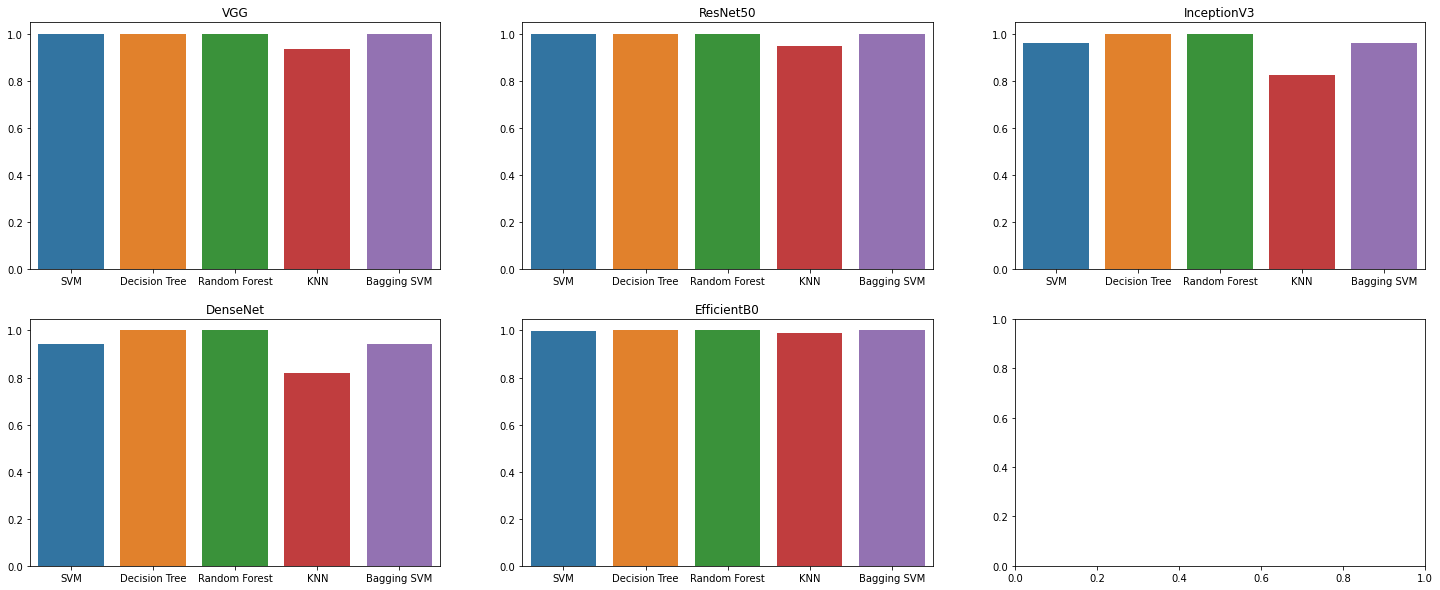

In [60]:
#Training Accuracy
import seaborn as sns
vgg_max_training=[]
res_max_training=[]
inc_max_training=[]
dense_max_training=[]
eff_max_training=[]

max_train_acc=[vgg_max_training,res_max_training,inc_max_training,dense_max_training,eff_max_training]
indexes=[]

fig,axs=plt.subplots(ncols=3,nrows=2)
fig.set_size_inches(25,10)

dl=['VGG','ResNet50', 'InceptionV3','DenseNet','EfficientB0']
k=0
l=-1
for j in range(0,5):
  max=0
  index=0
  algos = ['SVM', 'Decision Tree', 'Random Forest', 'KNN', 'Bagging SVM']
  for i in range(0,5):
    if max<=acc_train[j][i]:
      max=acc_train[j][i]
      index=i
  if j>2 and j<4:
    l=-1
  if j>2:
    k=1

  l+=1
  axs[k,l].set_title(dl[j])
  ax=sns.barplot(x=algos,y=acc_train[j],ax=axs[k,l])
  max_train_acc[j].append(max)
  indexes.append(index)

In [61]:
values=[0]*5
for i in range(0,len(max_train_acc)):
  for j in range(0,len(acc_train[i])):
    if max_train_acc[i]==acc_train[i][j]:
      values[j]+=1

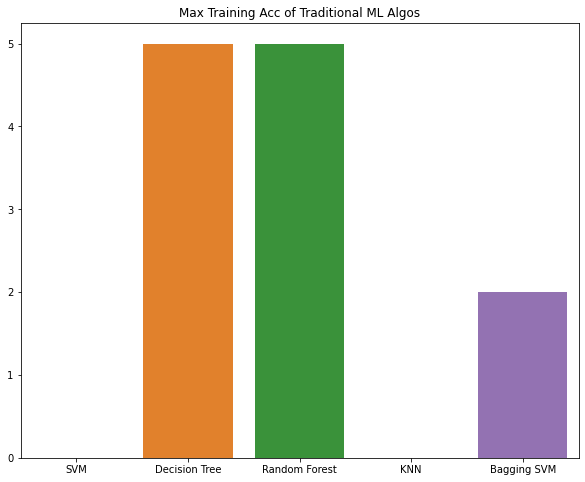

In [62]:
fig.set_size_inches(25,10)
algos = ['SVM', 'Decision Tree', 'Random Forest', 'KNN', 'Bagging SVM']
acc=values
plt.title('Max Training Acc of Traditional ML Algos')
ax=sns.barplot(x=algos,y=acc)

###Testing Accuracy

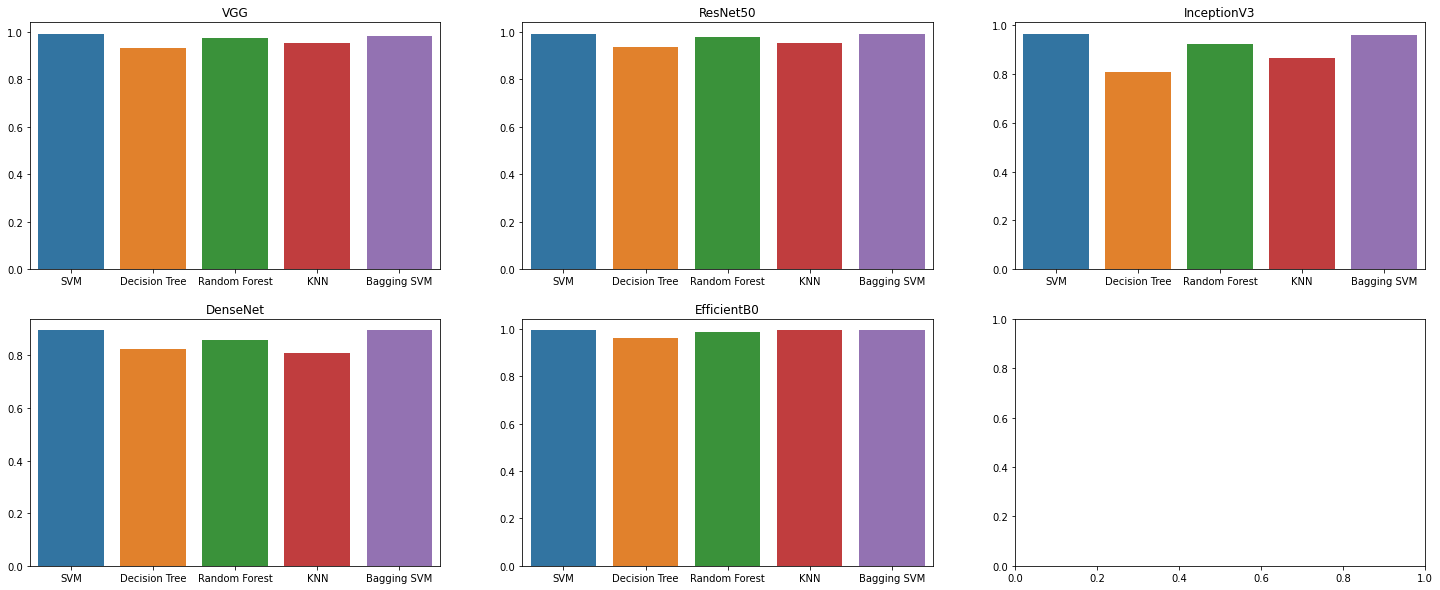

In [63]:
import seaborn as sns
#Testing Accuracy
vgg_max_testing=[]
res_max_testing=[]
inc_max_testing=[]
dense_max_testing=[]
eff_max_testing=[]

max_test_acc=[vgg_max_testing,res_max_testing,inc_max_testing,dense_max_testing,eff_max_testing]
indexes=[]
svm=0
fig,axs=plt.subplots(ncols=3,nrows=2)
fig.set_size_inches(25,10)

dl=['VGG','ResNet50', 'InceptionV3','DenseNet','EfficientB0']
k=0
l=-1
for j in range(0,5):
  max=0
  index=0
  algos = ['SVM', 'Decision Tree', 'Random Forest', 'KNN', 'Bagging SVM']
  for i in range(0,5):
    if max<=acc_test[j][i]:
      max=acc_test[j][i]
      index=i
  
  if j>2 and j<4:
    l=-1
  if j>2:
    k=1

  l+=1
  axs[k,l].set_title(dl[j])
  ax=sns.barplot(x=algos,y=acc_test[j],ax=axs[k,l])
  max_test_acc[j].append(max)
  indexes.append(index)

In [64]:
values=[0]*5
for i in range(0,len(max_test_acc)):
  for j in range(0,len(acc_test[i])):
    if max_test_acc[i]==acc_test[i][j]:
      values[j]+=1

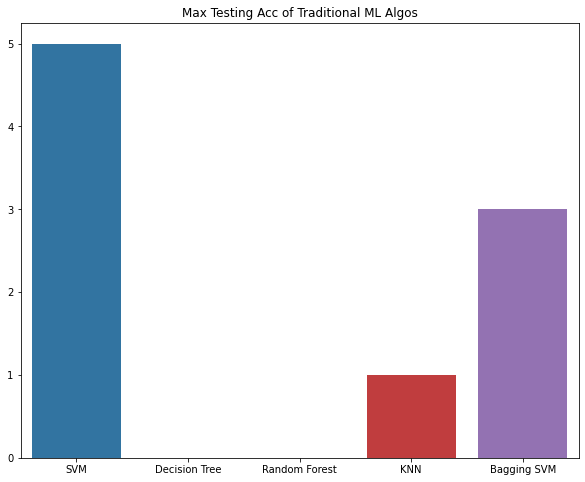

In [65]:
fig.set_size_inches(25,10)
algos = ['SVM', 'Decision Tree', 'Random Forest', 'KNN', 'Bagging SVM']
acc=values
plt.title('Max Testing Acc of Traditional ML Algos')
ax=sns.barplot(x=algos,y=acc)

In [66]:
acc_test

[[0.9900662251655629,
  0.9304635761589404,
  0.9735099337748344,
  0.9536423841059603,
  0.9801324503311258],
 [0.9900662251655629,
  0.9370860927152318,
  0.9768211920529801,
  0.9503311258278145,
  0.9900662251655629],
 [0.9635761589403974,
  0.8079470198675497,
  0.9238410596026491,
  0.8642384105960265,
  0.9602649006622517],
 [0.8940397350993378,
  0.8245033112582781,
  0.8576158940397351,
  0.8079470198675497,
  0.8940397350993378],
 [0.9933774834437086,
  0.9602649006622517,
  0.9867549668874173,
  0.9933774834437086,
  0.9933774834437086]]